In [1]:
import os
import pandas as pd
from glob import glob
from sklearn.model_selection import StratifiedKFold

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
dataset_root = "melanoma_cancer_dataset/train"

image_paths = []
labels = []

class_names = sorted(os.listdir(dataset_root))  # keep consistent class order

for label in class_names:
    class_dir = os.path.join(dataset_root, label)
    if os.path.isdir(class_dir):
        img_files = glob(os.path.join(class_dir, "*.jpg")) + \
                    glob(os.path.join(class_dir, "*.png")) + \
                    glob(os.path.join(class_dir, "*.jpeg"))
        image_paths.extend(img_files)
        labels.extend([label] * len(img_files))

df = pd.DataFrame({"image": image_paths, "label": labels})
print(df.head())
print("Total images:", len(df))
print("Classes:", class_names)


                                               image   label
0  melanoma_cancer_dataset/train/benign/melanoma_...  benign
1  melanoma_cancer_dataset/train/benign/melanoma_...  benign
2  melanoma_cancer_dataset/train/benign/melanoma_...  benign
3  melanoma_cancer_dataset/train/benign/melanoma_...  benign
4  melanoma_cancer_dataset/train/benign/melanoma_...  benign
Total images: 9605
Classes: ['benign', 'malignant']


In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label_idx"] = le.fit_transform(df["label"])

num_classes = len(le.classes_)
print("Class to Index Mapping:", dict(zip(le.classes_, range(num_classes))))


Class to Index Mapping: {'benign': 0, 'malignant': 1}


In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df["fold"] = -1
for fold, (_, val_idx) in enumerate(skf.split(df["image"], df["label_idx"])):
    df.loc[val_idx, "fold"] = fold

df["fold"].value_counts()


fold
1    1921
2    1921
0    1921
3    1921
4    1921
Name: count, dtype: int64

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [6]:
class SkinCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image"]
        label = self.df.loc[idx, "label_idx"]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, label


In [7]:
def get_dataloaders(fold, batch_size=64):
    train_df = df[df.fold != fold]
    val_df = df[df.fold == fold]

    train_dataset = SkinCancerDataset(train_df, transform=train_transform)
    val_dataset = SkinCancerDataset(val_df, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=2)
    return train_loader, val_loader


In [8]:
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def create_model(num_classes):
    weights = EfficientNet_B0_Weights.DEFAULT  # pretrained
    
    model = efficientnet_b0(weights=weights)

    # Freeze feature extractor initially
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace classifier for 9 classes
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model.to(device)


In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label_idx']),
    y=df['label_idx']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion


CrossEntropyLoss()

In [10]:
def get_optimizer(model, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    return optimizer


In [11]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    preds, targets = [], []
    
    for imgs, labels in tqdm(loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds.extend(outputs.argmax(dim=1).cpu().numpy())
        targets.extend(labels.cpu().numpy())

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='macro')
    return total_loss/len(loader), acc, f1


def validate_one_epoch(model, loader):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='macro')
    return total_loss/len(loader), acc, f1


In [12]:
EPOCHS = 10  # can increase later if time allows
BATCH_SIZE = 32

fold_performance = []

for fold in range(5):
    print(f"\n===== FOLD {fold+1} / 5 =====")
    
    train_loader, val_loader = get_dataloaders(fold, batch_size=BATCH_SIZE)
    model = create_model(num_classes)
    optimizer = get_optimizer(model)

    best_f1 = 0
    best_model_path = f"best_bin_model_fold{fold}.pt"

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_acc, val_f1 = validate_one_epoch(model, val_loader)

        print(f"Train Loss: {train_loss:.4f} | ACC: {train_acc:.4f} | F1: {train_f1:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | ACC: {val_acc:.4f} | F1: {val_f1:.4f}")

        # Save best fold model
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), best_model_path)
            print(">>> Saved best model so far!")

    fold_performance.append({
        "fold": fold,
        "best_f1": best_f1
    })

print("\n=== Final Fold Results ===")
print(pd.DataFrame(fold_performance))



===== FOLD 1 / 5 =====

Epoch 1/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.27it/s]


Train Loss: 0.3921 | ACC: 0.8244 | F1: 0.8241
Val   Loss: 0.2944 | ACC: 0.8725 | F1: 0.8709
>>> Saved best model so far!

Epoch 2/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.84it/s]


Train Loss: 0.3422 | ACC: 0.8550 | F1: 0.8547
Val   Loss: 0.2869 | ACC: 0.8751 | F1: 0.8738
>>> Saved best model so far!

Epoch 3/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.77it/s]


Train Loss: 0.3337 | ACC: 0.8594 | F1: 0.8591
Val   Loss: 0.2756 | ACC: 0.8824 | F1: 0.8818
>>> Saved best model so far!

Epoch 4/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.64it/s]


Train Loss: 0.3362 | ACC: 0.8604 | F1: 0.8600
Val   Loss: 0.2742 | ACC: 0.8824 | F1: 0.8816

Epoch 5/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.42it/s]


Train Loss: 0.3321 | ACC: 0.8563 | F1: 0.8560
Val   Loss: 0.2804 | ACC: 0.8803 | F1: 0.8791

Epoch 6/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.44it/s]


Train Loss: 0.3407 | ACC: 0.8539 | F1: 0.8535
Val   Loss: 0.3612 | ACC: 0.8568 | F1: 0.8531

Epoch 7/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.46it/s]


Train Loss: 0.3304 | ACC: 0.8623 | F1: 0.8620
Val   Loss: 0.2729 | ACC: 0.8818 | F1: 0.8809

Epoch 8/10


Validating: 100%|███████████████████████████████| 61/61 [00:03<00:00, 19.58it/s]


Train Loss: 0.3295 | ACC: 0.8613 | F1: 0.8610
Val   Loss: 0.3108 | ACC: 0.8678 | F1: 0.8658

Epoch 9/10


Validating: 100%|███████████████████████████████| 61/61 [00:06<00:00,  9.98it/s]


Train Loss: 0.3277 | ACC: 0.8615 | F1: 0.8612
Val   Loss: 0.2719 | ACC: 0.8834 | F1: 0.8824
>>> Saved best model so far!

Epoch 10/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 11.15it/s]


Train Loss: 0.3373 | ACC: 0.8516 | F1: 0.8513
Val   Loss: 0.2922 | ACC: 0.8818 | F1: 0.8805

===== FOLD 2 / 5 =====

Epoch 1/10


Validating: 100%|███████████████████████████████| 61/61 [00:06<00:00, 10.10it/s]


Train Loss: 0.3875 | ACC: 0.8339 | F1: 0.8337
Val   Loss: 0.3004 | ACC: 0.8761 | F1: 0.8756
>>> Saved best model so far!

Epoch 2/10


Validating: 100%|███████████████████████████████| 61/61 [00:06<00:00, 10.14it/s]


Train Loss: 0.3471 | ACC: 0.8510 | F1: 0.8506
Val   Loss: 0.2866 | ACC: 0.8834 | F1: 0.8829
>>> Saved best model so far!

Epoch 3/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.32it/s]


Train Loss: 0.3434 | ACC: 0.8476 | F1: 0.8472
Val   Loss: 0.2773 | ACC: 0.8808 | F1: 0.8805

Epoch 4/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.87it/s]


Train Loss: 0.3300 | ACC: 0.8568 | F1: 0.8565
Val   Loss: 0.2989 | ACC: 0.8777 | F1: 0.8765

Epoch 5/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.60it/s]


Train Loss: 0.3405 | ACC: 0.8509 | F1: 0.8505
Val   Loss: 0.3003 | ACC: 0.8798 | F1: 0.8784

Epoch 6/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.47it/s]


Train Loss: 0.3412 | ACC: 0.8520 | F1: 0.8517
Val   Loss: 0.2852 | ACC: 0.8803 | F1: 0.8796

Epoch 7/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.42it/s]


Train Loss: 0.3316 | ACC: 0.8558 | F1: 0.8554
Val   Loss: 0.2791 | ACC: 0.8860 | F1: 0.8858
>>> Saved best model so far!

Epoch 8/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.58it/s]


Train Loss: 0.3278 | ACC: 0.8589 | F1: 0.8587
Val   Loss: 0.2760 | ACC: 0.8855 | F1: 0.8847

Epoch 9/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.91it/s]


Train Loss: 0.3391 | ACC: 0.8567 | F1: 0.8564
Val   Loss: 0.2797 | ACC: 0.8881 | F1: 0.8875
>>> Saved best model so far!

Epoch 10/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.42it/s]


Train Loss: 0.3374 | ACC: 0.8570 | F1: 0.8567
Val   Loss: 0.2784 | ACC: 0.8808 | F1: 0.8800

===== FOLD 3 / 5 =====

Epoch 1/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 11.11it/s]


Train Loss: 0.3998 | ACC: 0.8256 | F1: 0.8253
Val   Loss: 0.2910 | ACC: 0.8818 | F1: 0.8818
>>> Saved best model so far!

Epoch 2/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 11.52it/s]


Train Loss: 0.3602 | ACC: 0.8447 | F1: 0.8444
Val   Loss: 0.2547 | ACC: 0.8907 | F1: 0.8904
>>> Saved best model so far!

Epoch 3/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.75it/s]


Train Loss: 0.3489 | ACC: 0.8493 | F1: 0.8490
Val   Loss: 0.2686 | ACC: 0.8891 | F1: 0.8884

Epoch 4/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.56it/s]


Train Loss: 0.3367 | ACC: 0.8544 | F1: 0.8540
Val   Loss: 0.2633 | ACC: 0.8824 | F1: 0.8819

Epoch 5/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.34it/s]


Train Loss: 0.3438 | ACC: 0.8532 | F1: 0.8529
Val   Loss: 0.2658 | ACC: 0.8803 | F1: 0.8796

Epoch 6/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.34it/s]


Train Loss: 0.3353 | ACC: 0.8549 | F1: 0.8546
Val   Loss: 0.2705 | ACC: 0.8865 | F1: 0.8854

Epoch 7/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.71it/s]


Train Loss: 0.3436 | ACC: 0.8518 | F1: 0.8513
Val   Loss: 0.2549 | ACC: 0.8969 | F1: 0.8969
>>> Saved best model so far!

Epoch 8/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.35it/s]


Train Loss: 0.3456 | ACC: 0.8496 | F1: 0.8492
Val   Loss: 0.2432 | ACC: 0.9021 | F1: 0.9018
>>> Saved best model so far!

Epoch 9/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.65it/s]


Train Loss: 0.3466 | ACC: 0.8496 | F1: 0.8492
Val   Loss: 0.2474 | ACC: 0.8912 | F1: 0.8909

Epoch 10/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.40it/s]


Train Loss: 0.3262 | ACC: 0.8614 | F1: 0.8611
Val   Loss: 0.2514 | ACC: 0.8922 | F1: 0.8918

===== FOLD 4 / 5 =====

Epoch 1/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.45it/s]


Train Loss: 0.3897 | ACC: 0.8246 | F1: 0.8244
Val   Loss: 0.2755 | ACC: 0.8876 | F1: 0.8868
>>> Saved best model so far!

Epoch 2/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.49it/s]


Train Loss: 0.3388 | ACC: 0.8550 | F1: 0.8547
Val   Loss: 0.2777 | ACC: 0.8891 | F1: 0.8882
>>> Saved best model so far!

Epoch 3/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.43it/s]


Train Loss: 0.3420 | ACC: 0.8545 | F1: 0.8541
Val   Loss: 0.2727 | ACC: 0.8850 | F1: 0.8840

Epoch 4/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.29it/s]


Train Loss: 0.3433 | ACC: 0.8532 | F1: 0.8529
Val   Loss: 0.2679 | ACC: 0.8907 | F1: 0.8900
>>> Saved best model so far!

Epoch 5/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.20it/s]


Train Loss: 0.3360 | ACC: 0.8532 | F1: 0.8529
Val   Loss: 0.2776 | ACC: 0.8829 | F1: 0.8819

Epoch 6/10


Validating: 100%|███████████████████████████████| 61/61 [00:06<00:00, 10.03it/s]


Train Loss: 0.3414 | ACC: 0.8566 | F1: 0.8563
Val   Loss: 0.2591 | ACC: 0.8959 | F1: 0.8953
>>> Saved best model so far!

Epoch 7/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.25it/s]


Train Loss: 0.3298 | ACC: 0.8615 | F1: 0.8613
Val   Loss: 0.2614 | ACC: 0.8959 | F1: 0.8953

Epoch 8/10


Validating: 100%|███████████████████████████████| 61/61 [00:06<00:00, 10.07it/s]


Train Loss: 0.3307 | ACC: 0.8559 | F1: 0.8555
Val   Loss: 0.2581 | ACC: 0.8922 | F1: 0.8918

Epoch 9/10


Validating: 100%|███████████████████████████████| 61/61 [00:06<00:00, 10.10it/s]


Train Loss: 0.3310 | ACC: 0.8555 | F1: 0.8553
Val   Loss: 0.2666 | ACC: 0.8896 | F1: 0.8891

Epoch 10/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.28it/s]


Train Loss: 0.3396 | ACC: 0.8545 | F1: 0.8542
Val   Loss: 0.2658 | ACC: 0.8902 | F1: 0.8895

===== FOLD 5 / 5 =====

Epoch 1/10


Validating: 100%|███████████████████████████████| 61/61 [00:06<00:00, 10.13it/s]


Train Loss: 0.3987 | ACC: 0.8267 | F1: 0.8262
Val   Loss: 0.2822 | ACC: 0.8865 | F1: 0.8856
>>> Saved best model so far!

Epoch 2/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.31it/s]


Train Loss: 0.3434 | ACC: 0.8488 | F1: 0.8485
Val   Loss: 0.2644 | ACC: 0.8907 | F1: 0.8903
>>> Saved best model so far!

Epoch 3/10


Validating: 100%|███████████████████████████████| 61/61 [00:06<00:00, 10.17it/s]


Train Loss: 0.3409 | ACC: 0.8523 | F1: 0.8518
Val   Loss: 0.2630 | ACC: 0.8969 | F1: 0.8964
>>> Saved best model so far!

Epoch 4/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.23it/s]


Train Loss: 0.3358 | ACC: 0.8558 | F1: 0.8555
Val   Loss: 0.2701 | ACC: 0.8881 | F1: 0.8870

Epoch 5/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.34it/s]


Train Loss: 0.3355 | ACC: 0.8574 | F1: 0.8571
Val   Loss: 0.2850 | ACC: 0.8844 | F1: 0.8829

Epoch 6/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.24it/s]


Train Loss: 0.3426 | ACC: 0.8536 | F1: 0.8533
Val   Loss: 0.2677 | ACC: 0.8896 | F1: 0.8887

Epoch 7/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 10.75it/s]


Train Loss: 0.3384 | ACC: 0.8566 | F1: 0.8563
Val   Loss: 0.2508 | ACC: 0.9011 | F1: 0.9007
>>> Saved best model so far!

Epoch 8/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 11.13it/s]


Train Loss: 0.3376 | ACC: 0.8559 | F1: 0.8557
Val   Loss: 0.2848 | ACC: 0.8834 | F1: 0.8818

Epoch 9/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 11.02it/s]


Train Loss: 0.3314 | ACC: 0.8580 | F1: 0.8577
Val   Loss: 0.2619 | ACC: 0.8974 | F1: 0.8966

Epoch 10/10


Validating: 100%|███████████████████████████████| 61/61 [00:05<00:00, 11.01it/s]

Train Loss: 0.3247 | ACC: 0.8589 | F1: 0.8586
Val   Loss: 0.2583 | ACC: 0.8980 | F1: 0.8972

=== Final Fold Results ===
   fold   best_f1
0     0  0.882373
1     1  0.887532
2     2  0.901841
3     3  0.895291
4     4  0.900686


In [14]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Paths
BEST_MODEL_PATH = "best_bin_model_fold2.pt"  # <- Update fold if needed
TEST_DIR = "melanoma_cancer_dataset/test"

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Same transforms used in validation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load test dataset
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load model (EfficientNet B0)
from torchvision.models import efficientnet_b0
model = efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(test_dataset.classes))
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.to(device)
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Metrics
print("\n=== TEST SET RESULTS ===")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes, digits=4))

cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=test_dataset.classes, columns=test_dataset.classes)

print("\n=== CONFUSION MATRIX ===")
print(cm_df)


/home/rishabhjp/anaconda3/envs/miniproject/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabhjp/anaconda3/envs/miniproject/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_14352/1044385510.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for


=== TEST SET RESULTS ===
              precision    recall  f1-score   support

      benign     0.8828    0.9340    0.9077       500
   malignant     0.9299    0.8760    0.9022       500

    accuracy                         0.9050      1000
   macro avg     0.9064    0.9050    0.9049      1000
weighted avg     0.9064    0.9050    0.9049      1000


=== CONFUSION MATRIX ===
           benign  malignant
benign        467         33
malignant      62        438


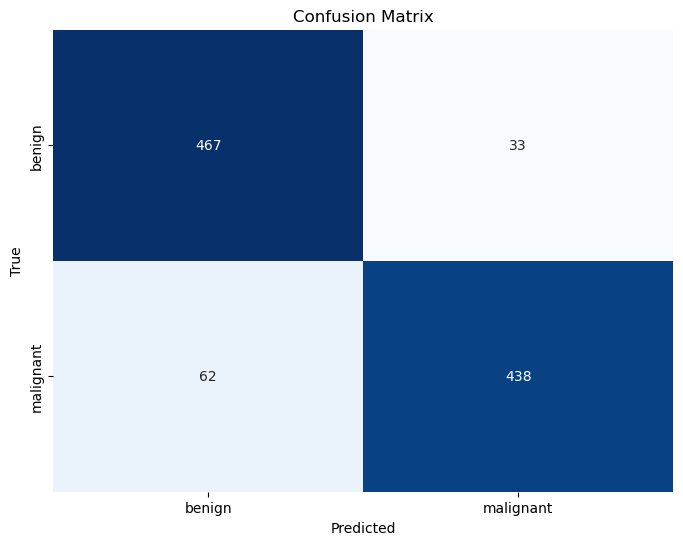

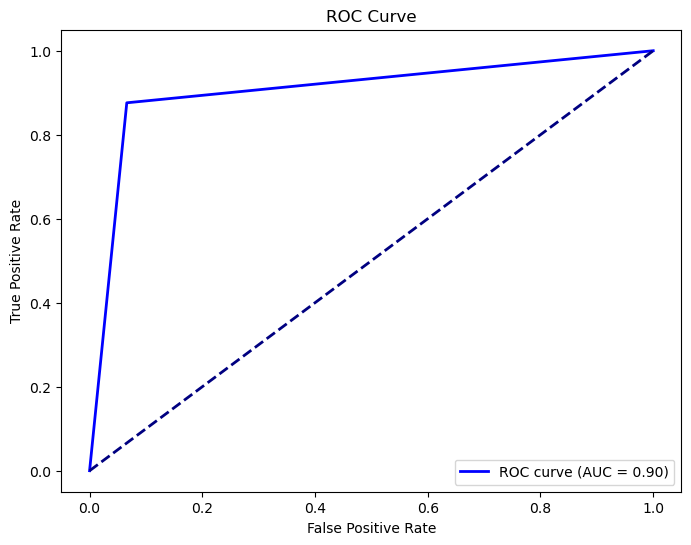

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Prepare labels for ROC AUC
y_true_bin = label_binarize(all_labels, classes=[0, 1])  # Assuming 'benign' = 0, 'malignant' = 1
y_pred_bin = label_binarize(all_preds, classes=[0, 1])

# ROC curve plotting
fpr, tpr, _ = roc_curve(y_true_bin, y_pred_bin)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
